In [120]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict, OrderedDict
from datetime import datetime

from matplotlib import pyplot as plt
import numpy as np

from benchmark import Options
from bench_api import *

def show_time(f):
    def _wrapper(*args):
        print(datetime.now())
        f(*args)
    return _wrapper

@show_time
def big():
    plt.rcParams["figure.figsize"] = (24, 15)
@show_time
def medium():
    plt.rcParams["figure.figsize"] = (16, 10)
@show_time
def ideal():
    plt.rcParams["figure.figsize"] = (10, 6)
@show_time
def small():
    plt.rcParams["figure.figsize"] = (6, 4)

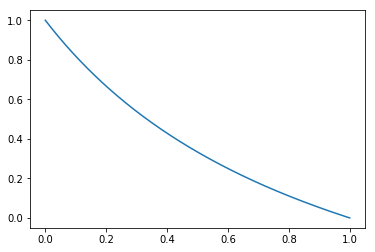

In [68]:
small()
x = np.linspace(0, 1, 1000)
y = np.abs(1-x)/(1+x)
plt.plot(x, y)

2017-05-27 00:48:47.711280


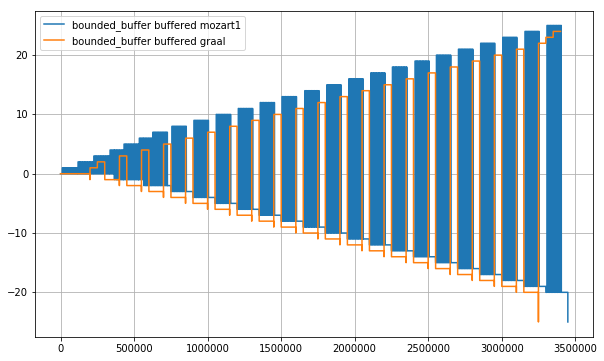

In [118]:
ideal()

active = Serie("boundedbuffer").get("active", conv=asis, sections=[0, 1])

active.plot(yscale=None, legend=0).grid().show()
plt.show()

2017-05-27 01:07:11.594105


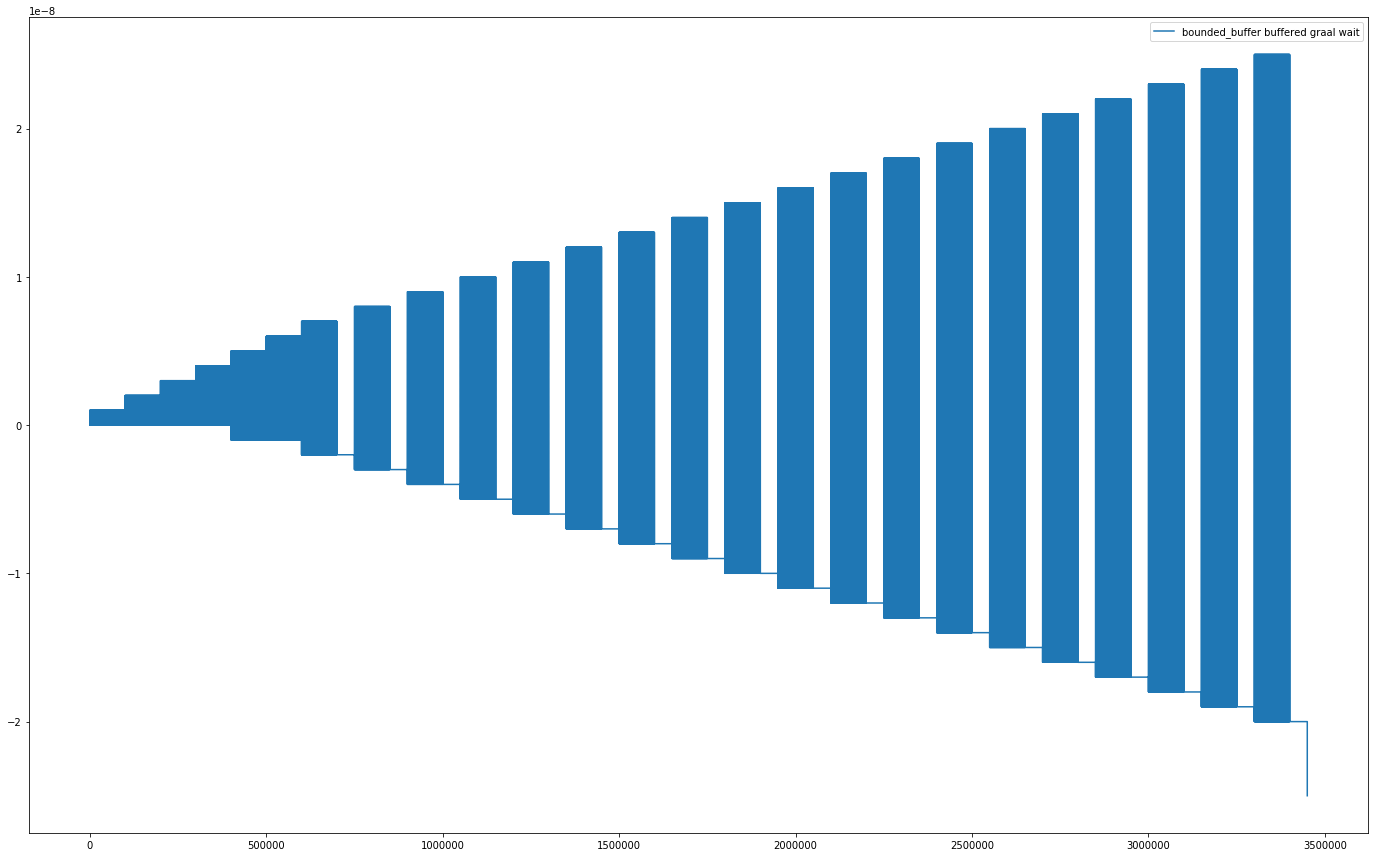

In [122]:
big()

active = Serie("boundedbuffer").get("active")

active.plot(yscale=None).show()
plt.show()

## Pow

In the following graphs, we can see, at the top, the cost of every iteration, and at the bottom, the cumulative time to reach the nth iteration (the plots are vertical in order to be correlated visually)

We can see that

- Graal generally ends up with much faster iterations than mozart2 and the simple truffle interpreter
- Mozart2 is still the big winner in terms of total execution time

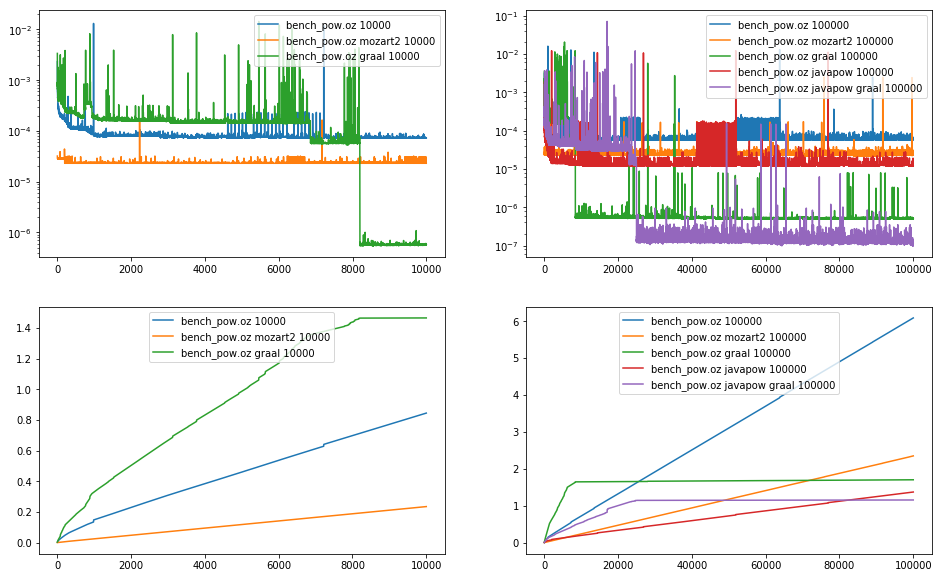

median [  7.39110000e-05   2.30000000e-05   1.44387500e-04]
median [  5.86140000e-05   2.30000000e-05   5.15000000e-07   1.23370000e-05
   1.32000000e-07]


In [2]:
medium()

pow_easy, pow_hard = Serie("pow")["10000", "100000"]

pow_easy.sub(221).plot()
pow_easy.sub(223).prog()

pow_hard.sub(222).plot()
pow_hard.sub(224).prog()
plt.show()

print("median", pow_easy.agg(np.median))
print("median", pow_hard.agg(np.median))

## Map

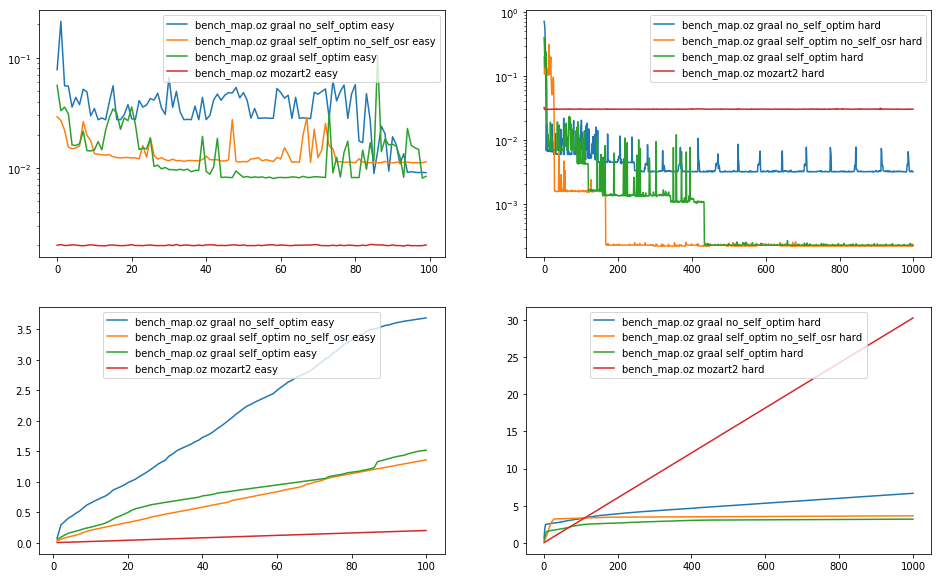

median [ 0.03486617  0.01191818  0.00998661  0.001997  ]
median [ 0.00321291  0.00022389  0.00022576  0.03025   ]


In [29]:
medium()

map_easy, map_hard = Serie("map")["easy", "hard"]

map_easy.sub(221).plot()
map_easy.sub(223).prog()

map_hard.sub(222).plot()
map_hard.sub(224).prog()
plt.show()

print("median", map_easy.agg(np.median))
print("median", map_hard.agg(np.median))

2017-05-23 01:54:01.938157


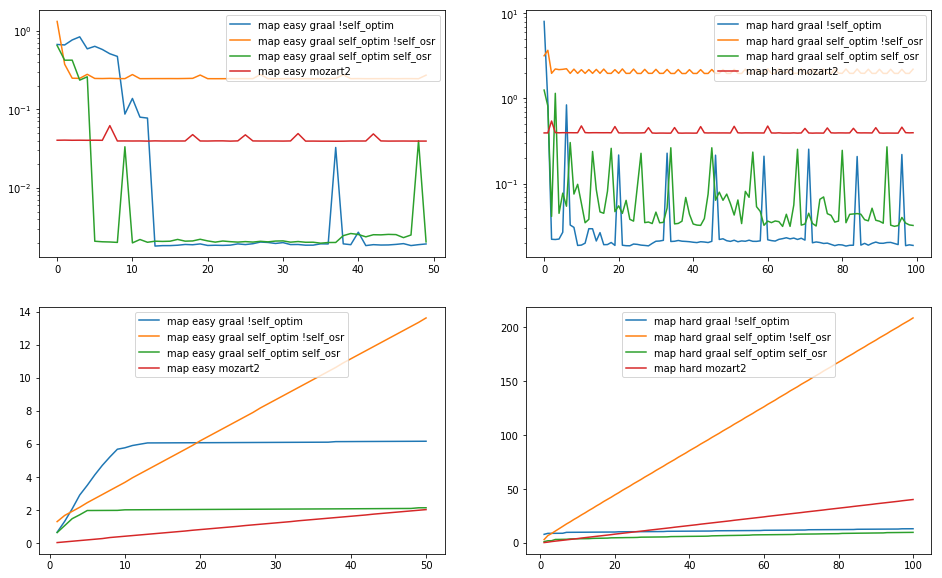

median [ 0.00193552  0.24492268  0.00210206  0.039424  ]
median [ 0.0209084   1.97307807  0.04381781  0.3939365 ]


In [24]:
medium()

map_easy, map_hard = Serie("map")["easy", "hard"]

map_easy.sub(221).plot()
map_easy.sub(223).prog()

map_hard.sub(222).plot()
map_hard.sub(224).prog()
plt.show()

print("median", map_easy.agg(np.median))
print("median", map_hard.agg(np.median))

2017-05-23 14:41:58.697774


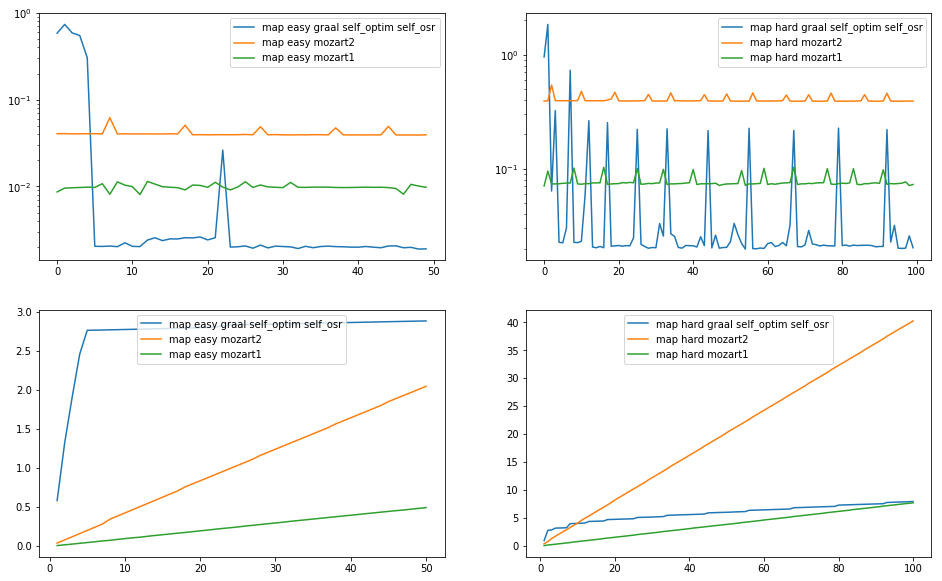

median [ 0.00204396  0.0395005   0.00978566]
median [ 0.02130177  0.3933695   0.07418895]


In [26]:
medium()

map_easy, map_hard = Serie("map")["easy", "hard"]

map_easy.sub(221).plot()
map_easy.sub(223).prog()

map_hard.sub(222).plot()
map_hard.sub(224).prog()
plt.show()

print("median", map_easy.agg(np.median))
print("median", map_hard.agg(np.median))

## Flatten

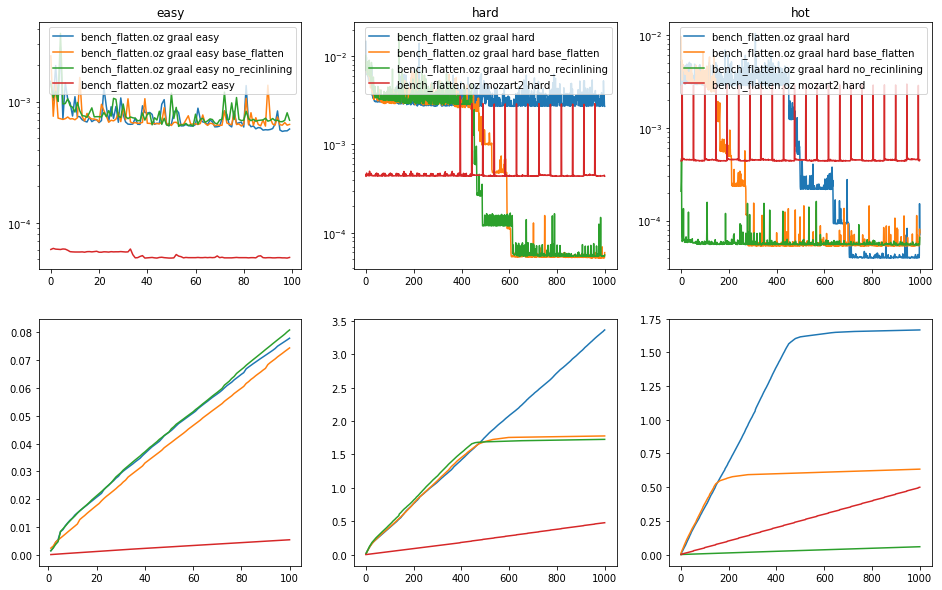

median [  6.78516276e-04   6.73702762e-04   7.27002269e-04   5.15976683e-05]
median [ 0.00306484  0.0010227   0.00015907  0.00044259]
median [  3.90552126e-04   5.46533605e-05   5.57371583e-05   4.45151366e-04]


In [28]:
medium()

flatten_easy, flatten_hard = Serie("flatten", n=range(5)).get(("easy", ("hard", "hard_hot")), agg=geomean)

flatten_hard, flatten_hot = flatten_hard
#flatten_hard = merge(flatten_hard, ["{}", "hot {}"])

flatten_easy.sub(231, title="easy").plot()
flatten_easy.sub(234).prog(legend=None)

flatten_hard.sub(232, title="hard").plot(legend=0)
flatten_hard.sub(235).prog(legend=None)

flatten_hot.sub(233, title="hot").plot()
flatten_hot.sub(236).prog(legend=None)

plt.show()

print("median", flatten_easy.agg(np.median))
print("median", flatten_hard.agg(np.median))
print("median", flatten_hot.agg(np.median))

2017-05-23 18:46:17.449239


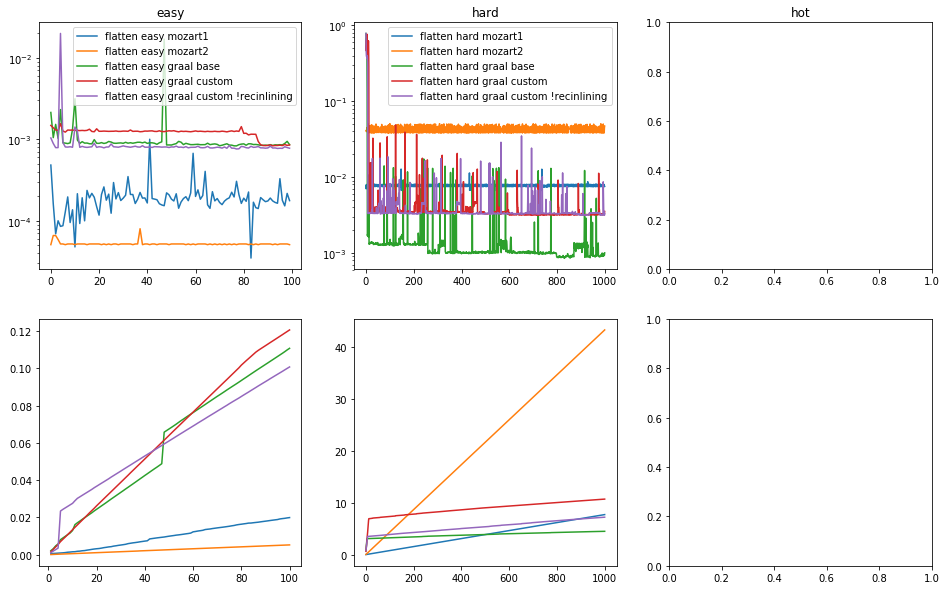

median [  1.84666000e-04   5.20000000e-05   8.87267500e-04   1.25183150e-03
   8.01872500e-04]
median [ 0.00764974  0.0436615   0.00102577  0.00344523  0.00332123]
median []


In [24]:
medium()

flatten_easy, flatten_hard = Serie("flatten", n=range(1)).get(("easy", ("hard", "hard_hot")), agg=geomean)

flatten_hard, flatten_hot = flatten_hard
#flatten_hard = merge(flatten_hard, ["{}", "hot {}"])

flatten_easy.sub(231, title="easy").plot()
flatten_easy.sub(234).prog(legend=None)

flatten_hard.sub(232, title="hard").plot(legend=0)
flatten_hard.sub(235).prog(legend=None)

flatten_hot.sub(233, title="hot").plot()
flatten_hot.sub(236).prog(legend=None)

plt.show()

print("median", flatten_easy.agg(np.median))
print("median", flatten_hard.agg(np.median))
print("median", flatten_hot.agg(np.median))

2017-05-25 11:42:40.137610


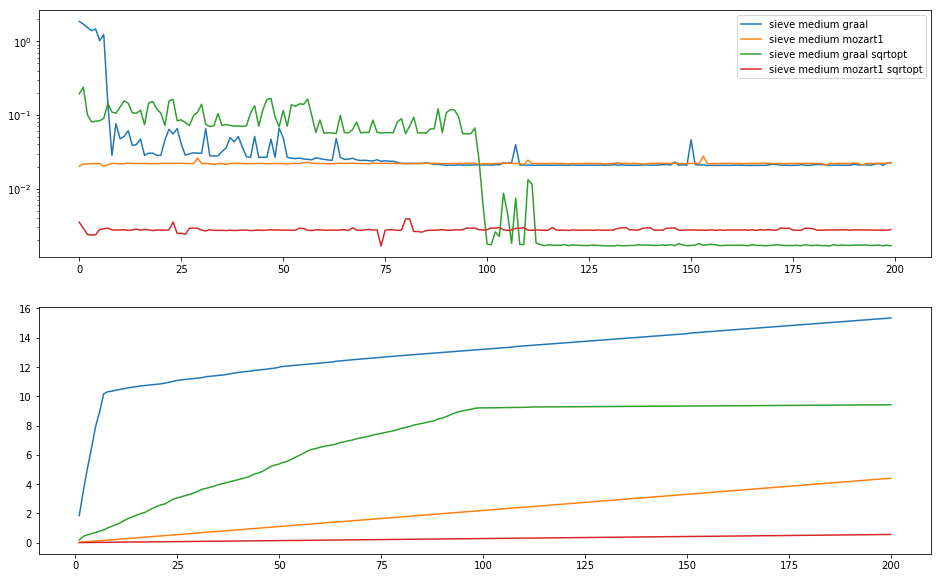

median [ 0.02139994  0.02200143  0.01239988  0.00275542]


In [22]:
medium()

sieve = Serie("sieve", n=range(1)).get("medium")

sieve.sub(211).plot()
sieve.sub(212).prog(legend=None)

plt.show()

print("median", sieve.agg(np.median))

2017-05-25 16:18:07.489495


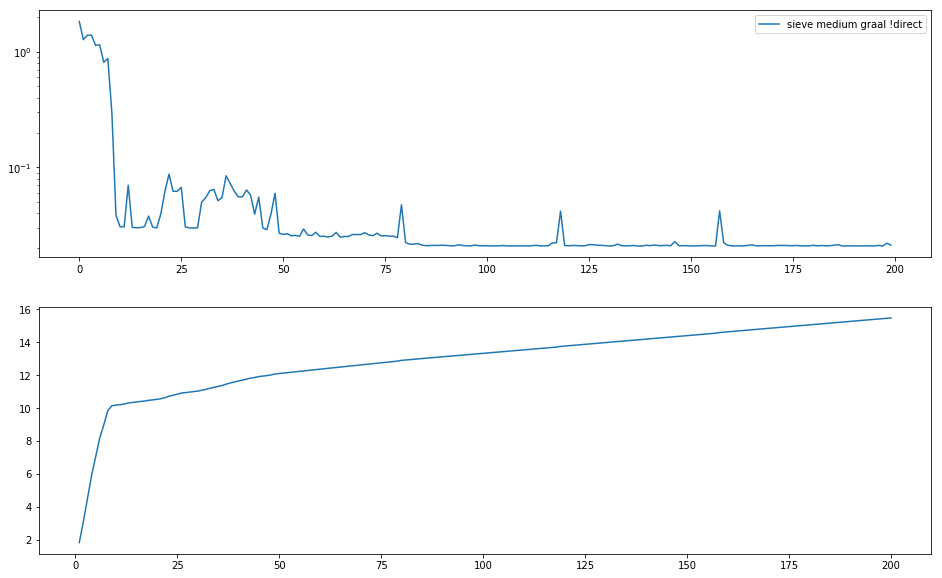

median [ 0.02126668]


In [35]:
medium()

sieve = Serie("sieve", n=range(1)).get("medium")

sieve.sub(211).plot()
sieve.sub(212).prog(legend=None)

plt.show()

print("median", sieve.agg(np.median))

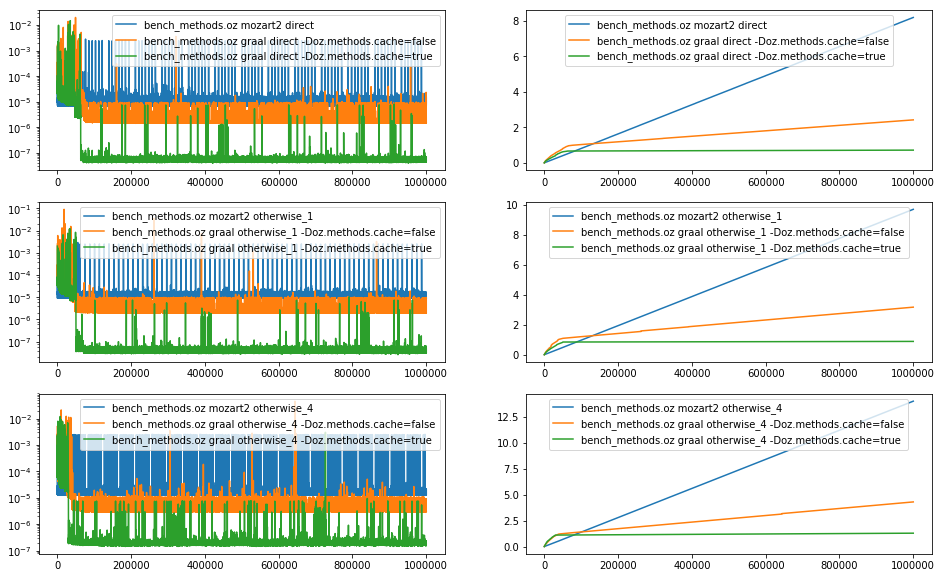

median [  8.00000000e-06   1.52100000e-06   5.40000000e-08]
median [  9.00000000e-06   2.11500000e-06   4.20000000e-08]
median [  1.30000000e-05   3.11100000e-06   1.79000000e-07]


In [57]:
medium()
# As of commit cb63d9c9f1ee2989ddcd80bc73d89c4ce6913af0
direct, otherwise_1, otherwise_4 = Serie("methods", n=range(1)).get(("direct", "otherwise_1", "otherwise_4"))

direct.sub(321).plot()
direct.sub(322).prog()
otherwise_1.sub(323).plot()
otherwise_1.sub(324).prog()
otherwise_4.sub(325).plot()
otherwise_4.sub(326).prog().show()

print("median", direct.agg(np.median))
print("median", otherwise_1.agg(np.median))
print("median", otherwise_4.agg(np.median))

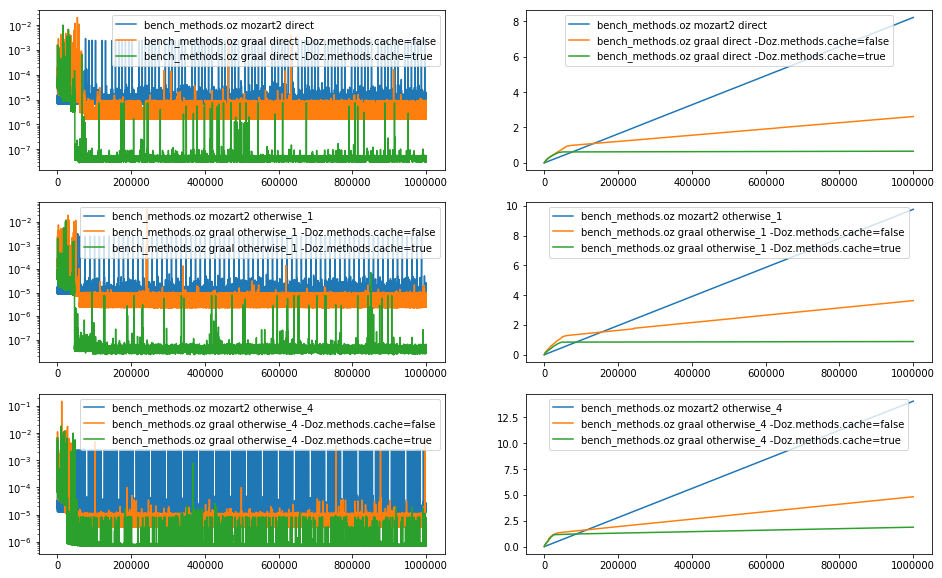

median [  8.00000000e-06   1.73500000e-06   4.30000000e-08]
median [  9.00000000e-06   2.43200000e-06   4.10000000e-08]
median [  1.30000000e-05   3.55300000e-06   7.13000000e-07]


In [60]:
medium()

direct, otherwise_1, otherwise_4 = Serie("methods", n=range(1)).get(("direct", "otherwise_1", "otherwise_4"))

direct.sub(321).plot()
direct.sub(322).prog()
otherwise_1.sub(323).plot()
otherwise_1.sub(324).prog()
otherwise_4.sub(325).plot()
otherwise_4.sub(326).prog().show()

print("median", direct.agg(np.median))
print("median", otherwise_1.agg(np.median))
print("median", otherwise_4.agg(np.median))

2017-05-25 18:03:57.323341


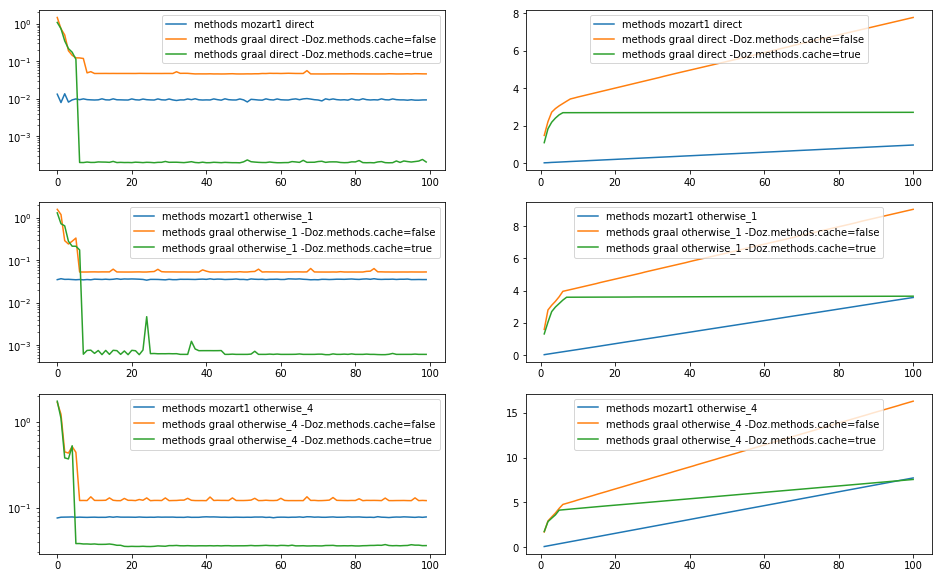

median [ 0.00949142  0.0470277   0.00020539]
median [ 0.03583609  0.05338171  0.0006149 ]
median [ 0.07733194  0.12139969  0.03593187]


In [45]:
medium()

direct, otherwise_1, otherwise_4 = Serie("methods", n=range(1)).get(("direct", "otherwise_1", "otherwise_4"))

direct.sub(321).plot()
direct.sub(322).prog()
otherwise_1.sub(323).plot()
otherwise_1.sub(324).prog()
otherwise_4.sub(325).plot()
otherwise_4.sub(326).prog().show()

print("median", direct.agg(np.median))
print("median", otherwise_1.agg(np.median))
print("median", otherwise_4.agg(np.median))

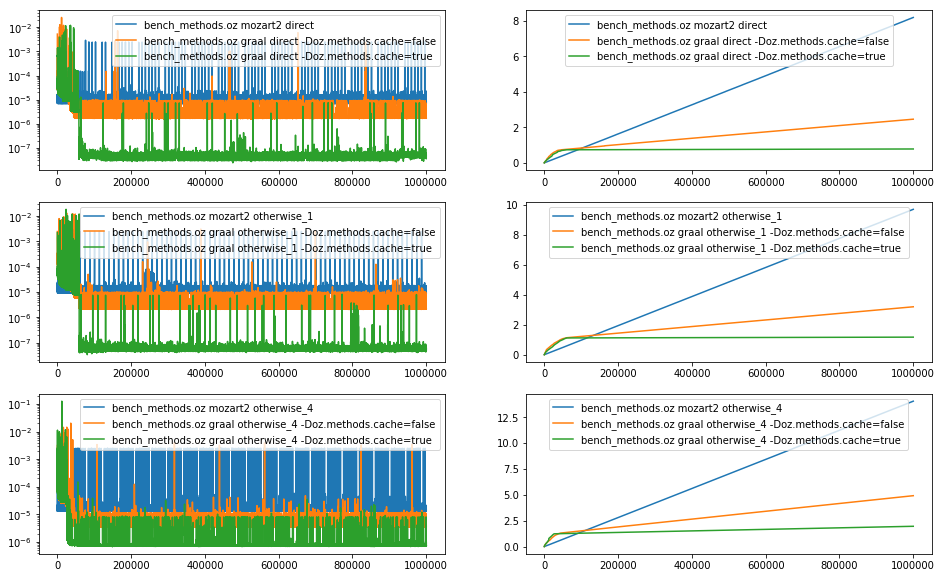

median [  8.00000000e-06   1.77000000e-06   4.70000000e-08]
median [  9.00000000e-06   2.16400000e-06   5.50000000e-08]
median [  1.30000000e-05   3.70000000e-06   7.34000000e-07]


In [64]:
medium()

direct, otherwise_1, otherwise_4 = Serie("methods", n=range(1)).get(("direct", "otherwise_1", "otherwise_4"))

direct.sub(321).plot()
direct.sub(322).prog()
otherwise_1.sub(323).plot()
otherwise_1.sub(324).prog()
otherwise_4.sub(325).plot()
otherwise_4.sub(326).prog().show()

print("median", direct.agg(np.median))
print("median", otherwise_1.agg(np.median))
print("median", otherwise_4.agg(np.median))

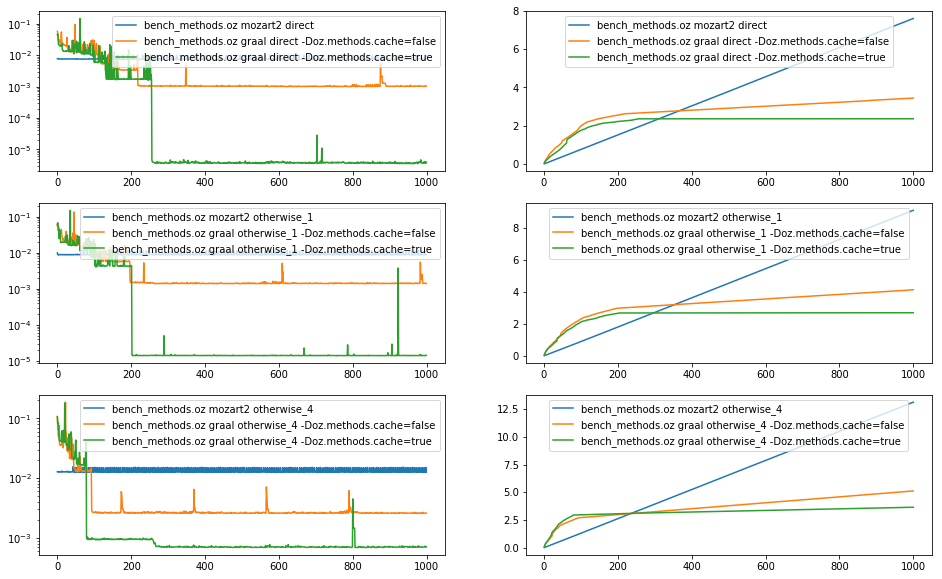

median [  7.43850000e-03   1.03208350e-03   3.81100000e-06]
median [  8.85400000e-03   1.42412900e-03   1.41270000e-05]
median [ 0.0126885   0.00262696  0.00070919]


In [66]:
medium()

direct, otherwise_1, otherwise_4 = Serie("methods", n=range(1)).get(("direct", "otherwise_1", "otherwise_4"))

direct.sub(321).plot()
direct.sub(322).prog()
otherwise_1.sub(323).plot()
otherwise_1.sub(324).prog()
otherwise_4.sub(325).plot()
otherwise_4.sub(326).prog().show()

print("median", direct.agg(np.median))
print("median", otherwise_1.agg(np.median))
print("median", otherwise_4.agg(np.median))

## Number of links

In [5]:
nlinks = Serie("nlinks").get("nlinks", conv=asis)
None

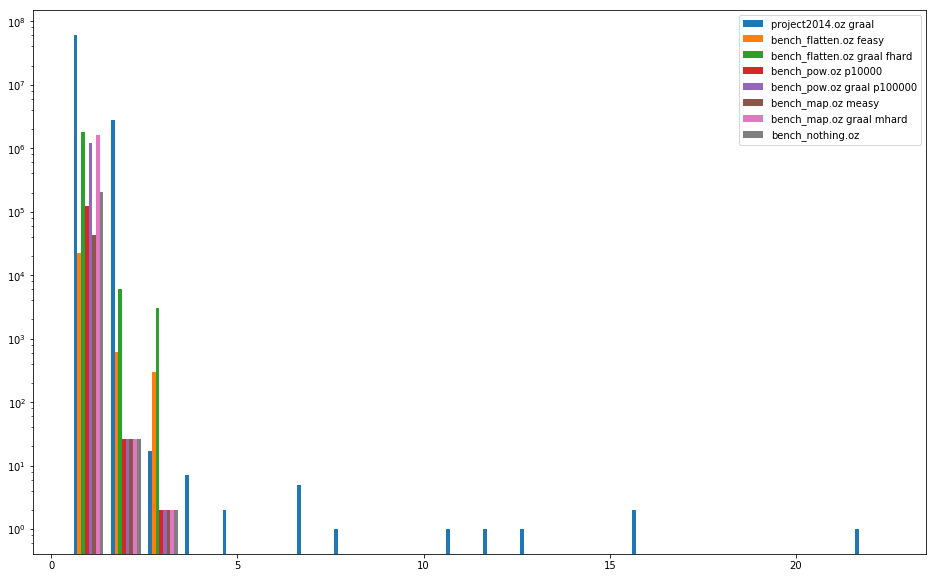

In [6]:
medium()
nlinks.hist().show()

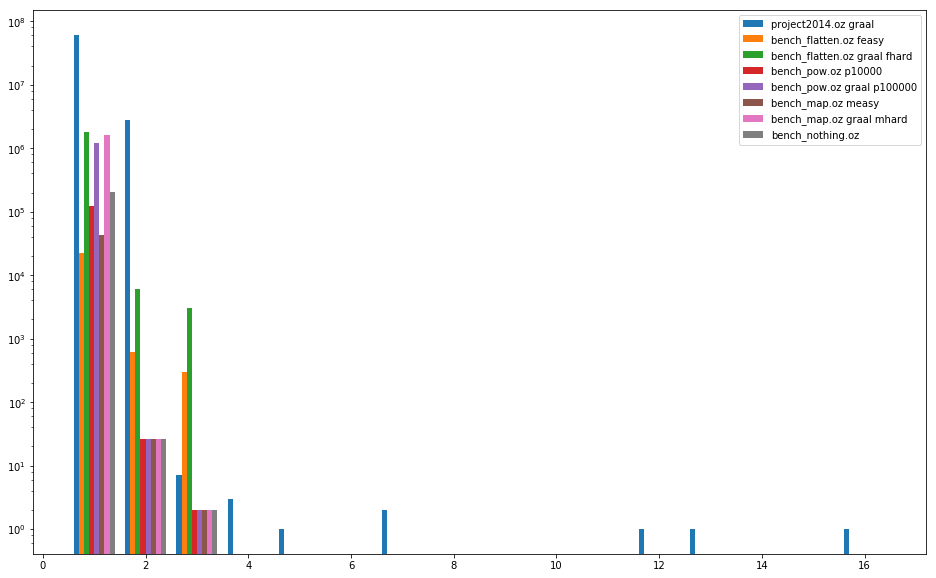

In [10]:
nlinks = Serie("nlinks").get("nlinks", conv=asis)
nlinks.hist().show()

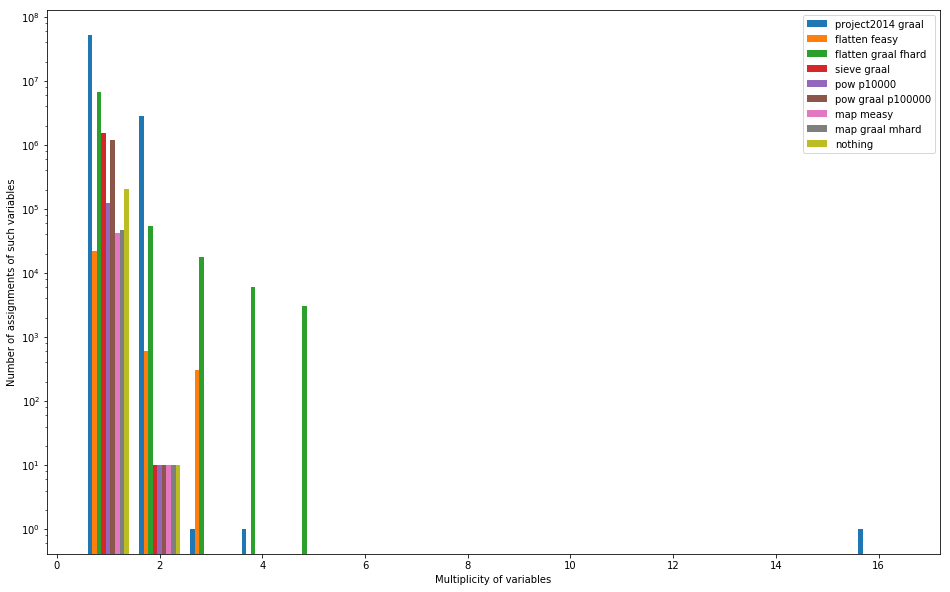

In [13]:
medium()
nlinks = Serie("nlinks").get("nlinks", conv=asis)
nlinks.hist()
plt.xlabel("Multiplicity of variables")
plt.ylabel("Number of assignments of such variables")
plt.show()

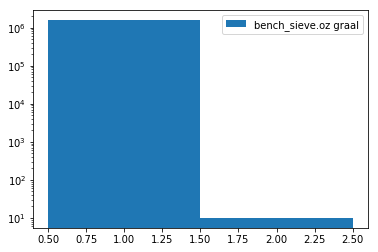

In [74]:
nlinks = Serie("nlinks").get("nlinks", conv=asis)
nlinks.hist().show()

In [21]:
# Without captured variables
nlinks = Serie("nvars").get("nvars", conv=asis)
nlinks.mat

[[83288050], [74816697]]

In [30]:
# Without optimization, with dynamic, with bad one
nlinks = Serie("nvars").get("nvars", conv=asis)
nlinks.mat

[[59047],
 [56237],
 [58625],
 [3660037],
 [3657227],
 [3659615],
 [139146],
 [136320],
 [138722],
 [1219146],
 [1216320],
 [1218722],
 [59652],
 [56821],
 [59229],
 [1623552],
 [1620721],
 [1623129],
 [219143],
 [216320],
 [218720]]

In [66]:
# With good static one, without
nlinks = Serie("nvars").get("nvars", conv=asis)
nlinks.mat

[[56560],
 [59047],
 [3657550],
 [3660037],
 [136647],
 [139146],
 [1216647],
 [1219146],
 [57148],
 [59652],
 [1621048],
 [1623552],
 [216647],
 [219143]]

## Project

In [7]:
print(Serie("project")["total"].sections)
Serie("project")["total"].mat

['project2014.oz mozart2', 'project2014.oz graal', 'project2014.oz graal no_unlink']


array([[ 24.397664  ],
       [ 16.03142228],
       [ 25.20116312]])

In [15]:
print(Serie("project")["total"].sections)
Serie("project")["total"].mat

['project2014.oz mozart2', 'project2014.oz graal', 'project2014.oz graal no_unlink']


array([[ 25.075385  ],
       [ 20.38533012],
       [ 23.74126553]])

In [75]:
print(Serie("project")["total"].sections)
print(Serie("project", n=range(20)).get("total", agg=mean).mat)
print(Serie("project", n=range(1)).get("nvars", conv=asis).mat)

['project2014.oz graal', 'project2014.oz graal lazyvars', 'project2014.oz graal no_unlink']
[[ 18.14043916]
 [ 19.04286377]
 [ 22.77929087]]
[[83288050], [74816695], [83288050]]


In [80]:
print(Serie("project")["total"].sections)
print(Serie("project", n=range(1)).get("total", agg=mean).mat)
print(Serie("project", n=range(1)).get("nvars", conv=asis).mat)

['project2014.oz graal no_direct', 'project2014.oz graal', 'project2014.oz graal no_unlink']
[[ 16.91007273]
 [ 20.76421235]
 [ 24.9695205 ]]
[[83288228], [74817332], [74817332]]


2017-05-23 17:17:04.241125
['project2014 mozart2', 'project2014 mozart1', 'project2014 graal']


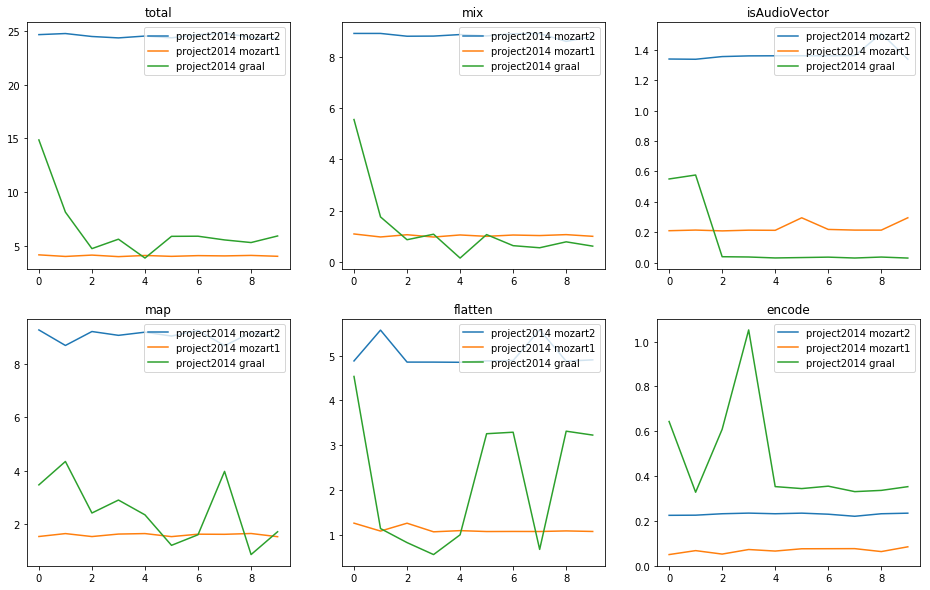

In [19]:
medium()
print(Serie("project")["total"].sections)
project = Serie("project", n=range(1))
total, mix, isAudio, map_, flatten, encode = project.get(("total", "mix", "isAudioVector", "mapped", "flattenned", "encoded"), agg=geomean)

total.sub(231, title="total").plot(yscale=None)
mix.sub(232, title="mix").plot(yscale=None)
isAudio.sub(233, title="isAudioVector").plot(yscale=None)
map_.sub(234, title="map").plot(yscale=None)
flatten.sub(235, title="flatten").plot(yscale=None)
encode.sub(236, title="encode").plot(yscale=None)
#print(Serie("project", n=range(1)).get("nvars", conv=asis).mat)

2017-05-23 17:46:15.654521
['project2014 mozart1', 'project2014 graal']


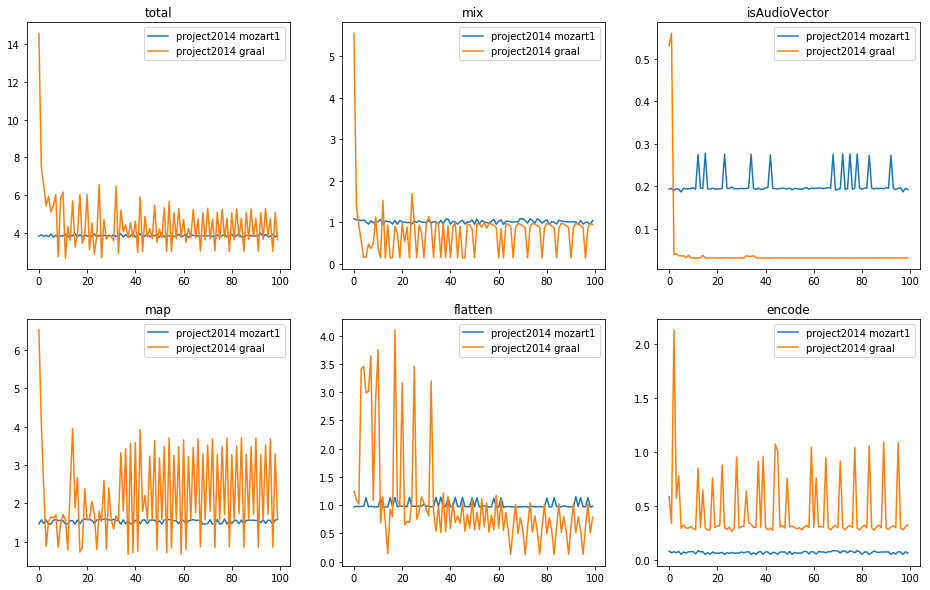

In [20]:
medium()
print(Serie("project")["total"].sections)
project = Serie("project", n=range(1))
total, mix, isAudio, map_, flatten, encode = project.get(("total", "mix", "isAudioVector", "mapped", "flattenned", "encoded"), agg=geomean)

total.sub(231, title="total").plot(yscale=None)
mix.sub(232, title="mix").plot(yscale=None)
isAudio.sub(233, title="isAudioVector").plot(yscale=None)
map_.sub(234, title="map").plot(yscale=None)
flatten.sub(235, title="flatten").plot(yscale=None)
encode.sub(236, title="encode").plot(yscale=None)
#print(Serie("project", n=range(1)).get("nvars", conv=asis).mat)

2017-05-24 09:00:31.614084
['project2014 mozart1', 'project2014 graal']


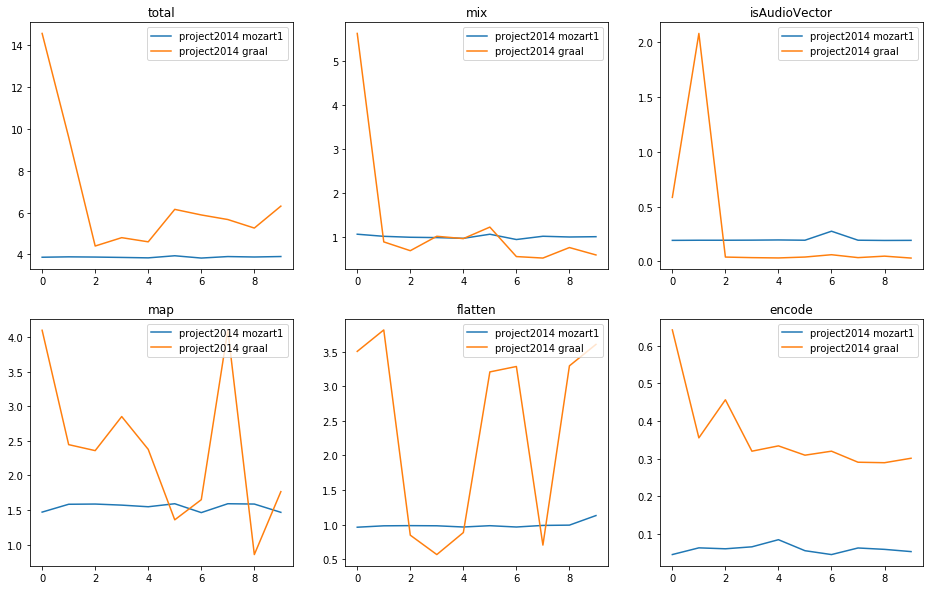

In [25]:
medium()
print(Serie("project")["total"].sections)
project = Serie("project", n=range(1))
total, mix, isAudio, map_, flatten, encode = project.get(("total", "mix", "isAudioVector", "mapped", "flattenned", "encoded"), agg=geomean)

total.sub(231, title="total").plot(yscale=None)
mix.sub(232, title="mix").plot(yscale=None)
isAudio.sub(233, title="isAudioVector").plot(yscale=None)
map_.sub(234, title="map").plot(yscale=None)
flatten.sub(235, title="flatten").plot(yscale=None)
encode.sub(236, title="encode").plot(yscale=None)
#print(Serie("project", n=range(1)).get("nvars", conv=asis).mat)

## Cost of measurements

Of course, in the previous graphs, it may have been possible the measure would be non-negligible in some results. Let's plot a no-op benchmark in order to see the order of magnitude

2017-05-24 15:24:37.308658


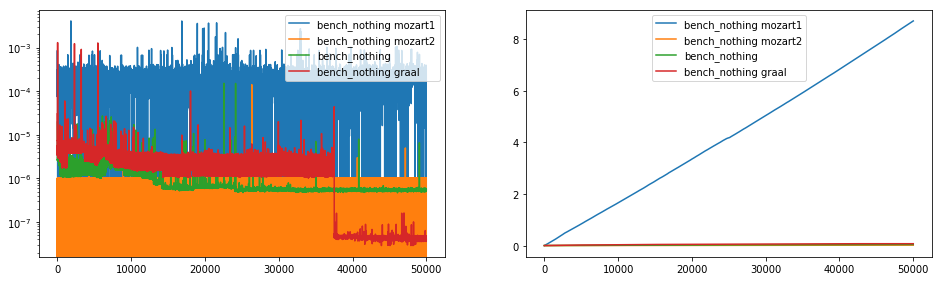

median [  1.74184500e-04   0.00000000e+00   5.71000000e-07   1.20200000e-06]


In [29]:
medium()

nothing = Serie("nothing")["50000"]
nothing.sub(221).plot()
nothing.sub(222).prog()
plt.show()

print("median", nothing.agg(np.median))